## License Plate Extraction Using YoloV5 and Pytesseract

In [1]:
# imports 
import cv2
import torch
import math
import os
import random
import xml.etree.ElementTree as ET
from utils_loc import ImageProcessingUtils as img_utils

##### 1.  Dataset Preparation
- Download the dataset from Kaggle [Link](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection)
- Dataset directory is `./dataset/pascal_voc_lic`
- Dataset are in Pascal voc format. 
- Yolo Dataset format are in the normalized height and weight 
- We need to convert the dataset to Yolo Dataset 

In [4]:
import shutil

# Global variables 
train_dir = None
val_dir = None

def create_yolo_dir_str(out_dir):
    """Used to create a different yolo directory for the conversion

    Args:
        out_dir (string): location of the output directory
    """
    # delete output dir
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    # create clean out directory
    os.makedirs(out_dir)
    # Create directories for YOLO dataset
    
    global train_dir
    global val_dir
    
    train_dir = os.path.join(out_dir, 'train')
    val_dir = os.path.join(out_dir, 'val')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(os.path.join(train_dir,"images"), exist_ok=True)
    os.makedirs(os.path.join(train_dir,"labels"), exist_ok=True)
    os.makedirs(os.path.join(val_dir,"images"), exist_ok=True)
    os.makedirs(os.path.join(val_dir,"labels"), exist_ok=True)
    

In [5]:
def data_format_yolo(inp_dir, out_dir, class_labels, split_ratio=0.8):
    """convert dataset to yolo format 

    Args:
        inp_dir (string): input directory with image and annotations 
        out_dir (string): output directory
        class_labels (dictionary): class string as key
        split_ratio (float, optional): train-val split Defaults to 0.8.
    """
    # input image and annotation directory
    image_dir = os.path.join(inp_dir, 'images')
    annotation_dir = os.path.join(inp_dir, 'annotations')
    
    # create yolo structure
    create_yolo_dir_str(out_dir)
    
    # Get the list of image files
    image_files = os.listdir(image_dir)
    # randomize the list
    random.shuffle(image_files)
    
    # Calculate the split point for train and validation sets
    split_point = int(len(image_files) * split_ratio)

    # Process each image and annotation file
    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        annotation_file = os.path.splitext(image_file)[0] + '.xml'
        annotation_path = os.path.join(annotation_dir, annotation_file)

        # Read the XML annotation file
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Extract image size for normalization
        size = root.find('size')
        image_width = int(size.find('width').text)
        image_height = int(size.find('height').text)

        # Open the corresponding YOLO annotation file for writing
        if idx < split_point:
            output_dir = train_dir
        else:
            output_dir = val_dir
        
        # define output annotations and image directory
        output_annotation_dir=os.path.join(output_dir,"labels")
        output_img_dir=os.path.join(output_dir,"images")
        
        # copy the image 
        shutil.copy2(image_path,output_img_dir)
        
        # create annotation file
        yolo_annotation_file = os.path.splitext(image_file)[0] + '.txt'
        yolo_annotation_path = os.path.join(output_annotation_dir, yolo_annotation_file)
        with open(yolo_annotation_path, 'w') as f:

            # Process each object in the annotation
            for obj in root.iter('object'):
                class_name = obj.find('name').text
                if class_name not in class_labels:
                    continue  # Skip unknown classes

                class_idx = class_labels[class_name]

                # Extract bounding box coordinates
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                # Calculate normalized YOLO coordinates
                x_center = (xmin + xmax) / (2 * image_width)
                y_center = (ymin + ymax) / (2 * image_height)
                width = (xmax - xmin) / image_width
                height = (ymax - ymin) / image_height

                # Write the YOLO annotation to the file
                f.write(f"{class_idx} {x_center} {y_center} {width} {height}\n")


    print("Conversion complete!")


In [6]:
inp_dir="./dataset/pascal_voc_lic/"
out_dir="./dataset/yolo_dataset/"
# Only one class
class_labels={'licence': 0,}

data_format_yolo(inp_dir, out_dir, class_labels)

Conversion complete!


###### 1.1  Let's verify the Yolo conversion 

- We will print the bounding boxes over the converted dataset 

In [7]:
import matplotlib.pyplot as plt
import cv2

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    """convert yolo format annotation to bbox parameters

    Args:
        bboxes (list): bboxes from yolo output , x_c, y_c, w, h

    Returns:
        int: bbox params as xmin, ymin
    """
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax



# Plot bbox on the images with labels
# Expected format is Yolo annotation with normalized value

def plot_box(image, bboxes, labels, class_names):
    """plot bbox on the images

    Args:
        image (Matrix): input image
        bboxes (): _description_
        labels (_type_): _description_
        class_names (_type_): _description_

    Returns:
        matrix: formatted image
    """
    
    # get colors for each class
    colors = np.random.uniform(0, 255, size=(len(class_names), 3))
    
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        # get class name
        class_name = class_names[int(labels[box_num])]
        
        # put Bounding box on top of the image frame
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        # Writing Text 
        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        
        # put a opaque rectangle behind the text
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        
        # Put Text on the text box
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [8]:
import glob
import random
import numpy as np
# Function to plot images with the bounding boxes.
# class_names: list of classes
def plot(image_paths, label_paths, num_samples, class_names):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(150, 12))
    for i in range(num_samples):
        # randomly select image 
        j = random.randint(0,num_images-1)
        # read the image
        image = cv2.imread(all_training_images[j])
        
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, class_names)
        plt.subplot(num_samples,1, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

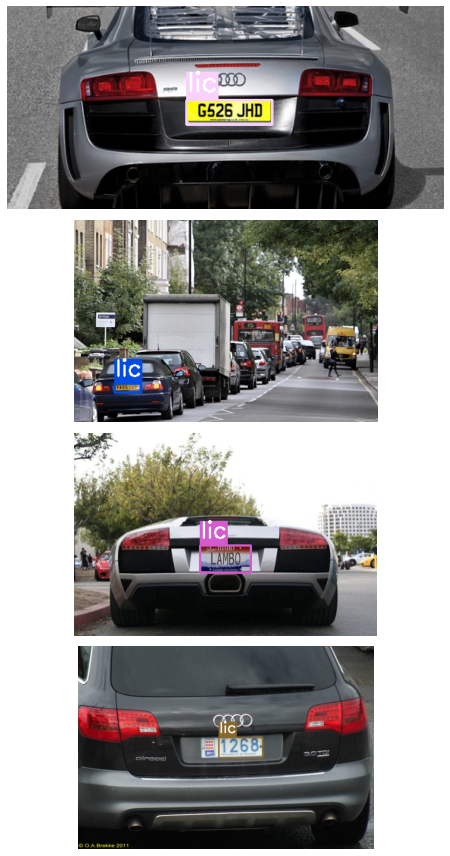

In [9]:
# Visualize a few training images.
class_names = ["lic"]
des_dir="./dataset/yolo_dataset/train/"
plot(
    image_paths=os.path.join(des_dir,"images/*"), 
    label_paths=os.path.join(des_dir,"labels/*"),
    num_samples=4,
    class_names=class_names
)

##### 2. Model Training 
- We have used [Ultralytics YoloV5](https://github.com/ultralytics/yolov5) model which is quite popular
- They have provided proper training script to do the training 

In [11]:
# Clone the git repository 
!git clone https://github.com/ultralytics/yolov5
# Go to directory
%cd yolov5
# Install the python requirements 
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15973, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 15973 (delta 84), reused 96 (delta 62), pack-reused 15831
Receiving objects: 100% (15973/15973), 14.63 MiB | 6.80 MiB/s, done.
Resolving deltas: 100% (10957/10957), done.
/Users/alokranjanswain/Documents/project/ML-Projects/Licence_Plate_Extraction/yolov5


- Before we proceed we require yaml file to be created for training. 
- The yaml should consist of the training images and validation images
###### Structure of yaml file 


- train: train_images_dir
- val: val_images_dir
- nc: number_of_classes
- names: class_labels_dict

In [16]:
import yaml

# Define key-value pairs
data = {
    'train': f'../{train_dir}/images',
    'val': f'../{val_dir}/images',
    'nc': 1,
    'names': {0: 'Licence_Plate'}
}

file_path = './lic_file.yaml'

# Write key-value pairs to the YAML file
with open(file_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)


###### Now let define some parameters for training 
- It look like 

!python train.py --data {YAML} --weights {WEIGHTS} --img {IMG_SZ} --epochs {EPOCHS} --batch-size {BATCH_SIZE}


- The trained object will be stored in `yolov5/runs/train/exp`
- Remember that `exp` is incremented everytime we re-run the script [`exp1`, `exp2`]

In [14]:
YAML = "./lic_file.yaml"
WEIGHTS = "yolov5s.pt" 
IMG_SZ = 640 # size images during training
EPOCHS = 20 # Number of epochs 
BATCH_SIZE = 16 

In [17]:
# Use the train script
# The script will automatically use the Cuda support for GPU 
# Recommend to use Google collab or Kaggle to train the network 

!python train.py --data {YAML} --weights yolov5s.pt --img {IMG_SZ} --epochs {EPOCHS} --batch-size {BATCH_SIZE} 

train: weights=yolov5s.pt, cfg=, data=./lic_file.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-181-g3812a1a Python-3.7.13 torch-1.13.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1


AutoAnchor: 4.08 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to runs/train/exp2/labels.jpg... 
Image sizes 480 train, 480 val
Using 8 dataloader workers
Logging results to runs/train/exp2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
  0%|          | 0/22 [00:10<?, ?it/s]
Traceback (most recent call last):
  File "train.py", line 647, in <module>
    main(opt)
  File "train.py", line 536, in main
    train(opt.hyp, opt, device, callbacks)
  File "train.py", line 291, in train
    for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
  File "/Users/alokranjanswain/opt/anaconda3/envs/deepLearn/lib/python3.7/site-packages/tqdm/std.py", line 1178, in __iter__
    for obj in iterable:
  File "/Users/alokranjanswain/Documents/project/ML-Projects/Licence_Plate_Extraction/yolov5/utils/dataloaders.py", l

In [18]:
# get out of `yolov5` directory 
%cd .. 

/Users/alokranjanswain/Documents/project/ML-Projects/Licence_Plate_Extraction


##### 3. Model Inference 
- The model is trained and stored as `lic_detection_model.pt` in the current folder 
- Currently we are only showing the detected objects for the output 

In [39]:
# Let's define some parameter for model inference 

thres_conf = 0.5 # threshold confidence, if the object is detected below this confidence, will be discarded 
cv_green = (0,255,0)
thickness = 2 # in pixel 
char_scale = 1 # scale of text to be put on the bounding box
class_label_list = ["license"] # class label list 

In [25]:
def load_model(model_path):
    model_yolo = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)
    model_yolo.eval()
    return model_yolo

In [40]:

def inference_on_single_frame(frame, model, size=640):
    """Draw bbox and class on the image infered through model

    Args:
        frame (ndarray): input image
        model : AI model
        size (int, optional): input size expected to the model, Defaults to 640.
    """
    
    # Resize the image to match the model expected input size
    input_size = (size, size)
    resized_image = cv2.resize(frame, input_size)
    
    # get Bounding boxes from the model
    results = model(resized_image, size=size)
    
    # iterate through detected objects
    for obj in results.pred[0]:
        
        xmin, ymin, xmax, ymax, conf, cat = obj.numpy()
        
        # Get integer value 
        xmin = math.floor(xmin)
        ymin = math.floor(ymin)
        xmax = math.ceil(xmax)
        ymax = math.ceil(ymax)
        
        if conf > thres_conf:
            # put the bounding box with green color
            cv2.rectangle(resized_image, (xmin, ymin), (xmax, ymax), cv_green, thickness)
            
            # Put text with green color
            cv2.putText(resized_image, class_label_list[int(cat)], (xmin, ymin -10), cv2.FONT_HERSHEY_SIMPLEX, 
                        char_scale, cv_green, thickness)
    
    # show image using image utils   
    img_utils.show_img(resized_image, "Output") 
        

- Now let's test some samples 


Using cache found in /Users/alokranjanswain/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-16 Python-3.7.13 torch-1.13.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


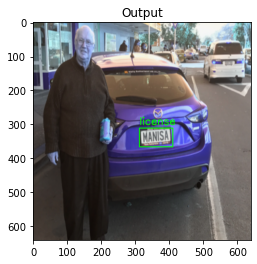

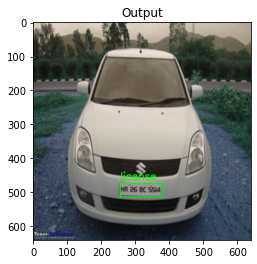

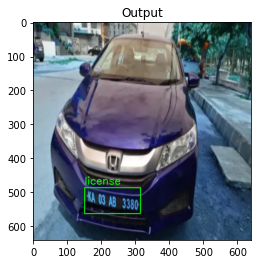

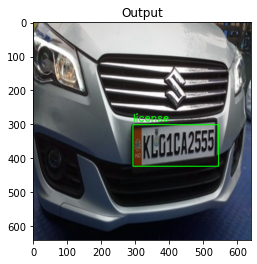

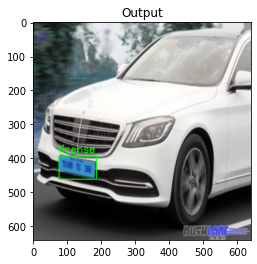

In [41]:
%matplotlib inline

# Load model
model_path="./Lic_Detection_model.pt"
model = load_model(model_path)

# get Image files from val directory 
img_dir= f'{val_dir}/images'
image_files=os.listdir(img_dir)
random.seed(38)
random.shuffle(image_files)

# Set num of sample to verify
num_samples = 5
for i in range(num_samples):
    img_name = image_files[i]
    image = cv2.imread(os.path.join(img_dir,img_name)) #BGR Format imread
    inference_on_single_frame(image, model, 640)

###### Object Detection Completed !!!
- It has been shown that the model is able to detect the license plate 
- Now let's move to ` text extraction ` 


##### 4. Text extraction
- Requirement is that tesseract installed in the machine 
- You should be able to import `pytesseract` 


In [44]:
# To see tesseract is installed in the PC [Optional] [Mandatory for google colab]
!tesseract -v

tesseract 5.3.1
 leptonica-1.82.0
  libgif 5.2.1 : libjpeg 8d (libjpeg-turbo 2.1.5.1) : libpng 1.6.39 : libtiff 4.5.0 : zlib 1.2.11 : libwebp 1.3.0 : libopenjp2 2.5.0
 Found NEON
 Found libarchive 3.6.2 zlib/1.2.11 liblzma/5.4.1 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.4
 Found libcurl/7.88.1 SecureTransport (LibreSSL/3.3.6) zlib/1.2.11 nghttp2/1.51.0


In [45]:
# install tesseract on google colab [optional for local/Kaggle] 
# Uncomment below two for installing on Ubuntu host
#!sudo apt install tesseract-ocr
#!tesseract -v

In [42]:
import pytesseract


In [91]:
def text_extract(image):
    """ Text Extraction on the cropped image with pytesseract 

    Args:
        cropped image 
    """    
    
    text_extracted= pytesseract.image_to_string(image, config='--psm 10')
#     text_extracted= pytesseract.image_to_string(image)
    
    if text_extracted == None:
        return ""
    
    return text_extracted


In [100]:
def detect_lic_on_frame(frame, model, size=640):
    """extract license number on a frame

    Args:
        frame (ndarray): input frame
        model (): yolov5 model
        size (int, optional): expected img size to model. Defaults to 640.

    Returns:
        output_frame:
    """
    # Resize the image to match the model expected input size
    input_size = (size, size)
    frame = cv2.resize(frame, input_size)
    
    # get Bounding boxes from the model
    results = model(frame, size=size)
    
    height, width, _ = frame.shape
    
    # Writing Text 
    font_scale = min(0.5,max(3,int(width/500)))
    font_thickness = min(2, max(10,int(width/50)))
    
    # iterate through detected objects
    for obj in results.pred[0]:
        
        xmin, ymin, xmax, ymax, conf, cat = obj.numpy()
        
        # Get integer value 
        xmin = math.floor(xmin)
        ymin = math.floor(ymin)
        xmax = math.ceil(xmax)
        ymax = math.ceil(ymax)
        
        # put the bounding box with green color
        cv2.rectangle(frame, (xmin,ymin),(xmax,ymax),cv_green,thickness)
        
        # Crop the image from the frame 
        crop_img=frame[ymin:ymax, xmin:xmax]
        
        # extract the text 
        txt_ext= text_extract(crop_img)
        
        cv2.putText(
                    frame, 
                    txt_ext,
                    (xmin , ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale,
                    (0,255,0),
                    font_thickness,
                   )
        
        return frame, txt_ext
        
    
    

##### 

##### 5. Show Result
- Let's see the result with respect to each frame
- The `inference` function will take images_path, and do inference on those images

In [102]:
def inferece(dir_path, model_path, num_samples):
    """run inference on some image samples 

    Args:
        dir_path (string): input image dir
        model_path (): yolov5 model
        num_samples (int): num of samples to be testeds
    """
    # Get a list of all the image filenames in the directory
    image_files = os.listdir(dir_path)
    random.shuffle(image_files)
    
    # load Yolo model
    model = load_model(model_path)
    
    # if inference is rqd for whole directory
    if num_samples<0:
        num_samples=len(image_files)
        
    for idx, image_name in enumerate(image_files):
        
        if idx >=num_samples:
            break
        
        # image read
        image = cv2.imread(os.path.join(dir_path,image_name))
        
        image, txt_ext = detect_lic_on_frame(image, model, size=640)
        
        # Save the image as JPEG
        output_path = 'output_image.jpg'
        cv2.imwrite(output_path, image, [cv2.IMWRITE_JPEG_QUALITY, 90])

        
        img_utils.show_img(image, "License Number extracted")
        print(" The Licence plate Extracted for the above image ", txt_ext)
        
        print("-------------------------------------------------------------------------- ")

Using cache found in /Users/alokranjanswain/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-16 Python-3.7.13 torch-1.13.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


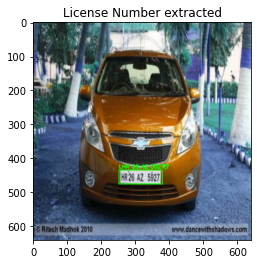

 The Licence plate Extracted for the above image  LHR 26 AZ 5027|

-------------------------------------------------------------------------- 


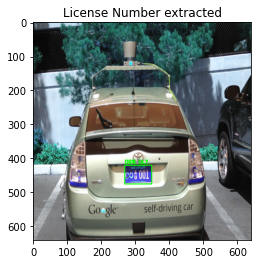

 The Licence plate Extracted for the above image  09% OL

-------------------------------------------------------------------------- 


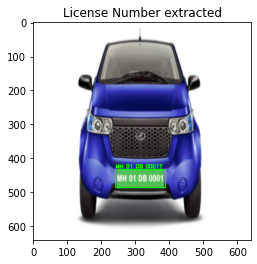

 The Licence plate Extracted for the above image  MH 01 DB 0001

-------------------------------------------------------------------------- 


In [103]:
%matplotlib inline
model_path="./Lic_Detection_model.pt"
img_path=f'{val_dir}/images'
random.seed(33)
inferece(img_path, model_path, 3)

#### Text Extraction Completed !!!
- We have successfully completed the text extraction over the images 
